## Build Score Model

### Objective

* Creates the comprehensive set of scoring models for all players and courses in the database, using an ElasticNetCV linear regression for weather parameters when a player has sufficient games on the same course, an ARIMA(0,1,0) model when a player has 4 or more game on the same course but not enough for a weather-based model, a same-course average if the player has one or more games on the same course, and an off-course average when a player has no games on the same course.  Also computes an estimated error from (in order of preference), same-course mse, all-course mse, or, when there is only one game available, an imputed first-vs-second game sme on either the same course or all-course, as the situation requires.  

### Rationale

*  Why This?  The models are a key component of the service offered by the system, and need a production-ready ETL method

*  Why Me?  As the main model architect, I am the logical choice

*  Why Now?  Successful trial runs with earlier models have accomplished preliminary optimization and established usefulness with user feedback.  Having a production-level model-building system now will enable us to receive maximum benefit from early deployments.

### Requirements

*  Pandas 0.24.2
*  Scikit-learn 0.21.2
*  Numpy 1.16.4
*  Matplotlib 3.1.0

### Input / Output

*  This notebook is expected to be in `models/notebooks`

*  The input weather data is in a file `models/wx_model_data/wx_model.csv`

*  The input score data is in a file `models/score_model_data/scores.csv`

*  The output models are stored in a file `models/score_model_data/score_model.csv` with a second copy as `models/scoer_model_data/score_model_{YYYYMMDD}{[a-z]}` where YYYYMMDD is the year, month, and day the model was generated, and a lower-case letter auto-increments for tracking.  `score_model.csv` is moved to `scoreCalculator/data` for deployed use.

### Import / Set-Up

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get weather data
wx_df = pd.read_csv('../wx_model_data/wx_model.csv', parse_dates = ['date'])
# Get scores data
scores_df = pd.read_csv('../score_model_data/scores.csv', parse_dates = ['time'])

In [3]:
wx_df.head()

,Unnamed: 0,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var,course_id
0,0,2018-11-11,62.987163,59.560057,5.091894,15.866667,26.821613,0.000000,2.632290,3.792724,2.382222,115.436274,111.370212,0
1,1,2018-12-09,49.491667,68.116667,3.919444,13.133333,90.988889,0.000000,2.100778,2.822686,2.915556,490.203981,41.108702,0
2,2,2018-12-17,52.000000,135.000000,0.000000,9.000000,93.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,3,2019-01-06,51.505556,153.133333,4.384722,20.933333,89.798611,0.105625,0.829178,-3.227827,6.995556,214.376551,906.500313,0
4,4,2019-08-03,56.631841,226.426190,3.021159,12.866667,96.149492,0.000203,-2.264058,-1.859965,1.448889,15.888444,17.074903,0


In [4]:
scores_df.head()

,id,Name,Raw,Handicap,Adjusted,time,course_id
0,0,Mark Shannon,61,-12.40,48.60,2019-01-19 08:00:00,1
1,1,Jacob Kermish-Wells,60,-10.72,49.28,2019-01-19 08:00:00,1
2,2,Luiz Celeste,55,-5.23,49.77,2019-01-19 08:00:00,1
3,3,Tu Tran,59,-9.07,49.93,2019-01-19 08:00:00,1
4,4,Matty Angell,53,-1.50,51.50,2019-01-19 08:00:00,1


In [5]:
# Clean out duplicated indexes
wx_df = wx_df.drop(columns = 'Unnamed: 0')
scores_df = scores_df.drop(columns = 'id')

In [6]:
# Sort prior to merge
wx_df = wx_df.sort_values(by = ['date','course_id'])
scores_df = scores_df.sort_values(by= ['time','course_id','Name'])

In [7]:
# Merge
all_df = pd.merge_asof(scores_df, wx_df, by = 'course_id', left_on= 'time', right_on = 'date',
                       direction = 'backward', tolerance = pd.Timedelta('1d') )
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
0,Alex Torres,68,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Andy Leaf,53,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Anthony McGinnis,78,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aurelius Lewicki,57,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Billy Manger,58,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Prepare imputation estimates 

* Use as needed for when players have only ever played once or got an unrealistically low variation in scores:
    * Single game on current course only -- use 1st game mean and historical 1st/2nd game average mse for all players on course
    * Single game on a different course -- use existing game mean and historical 1st/2nd game (different course) average mse for all players
    * Low standard deviation cut-off -- use the 5th percentile of all observed standard deviations

In [8]:
# Generate different course 1st to 2nd game estimate
player_names = all_df['Name'].unique()
diffs = []
for player in player_names:
    player_df = all_df[all_df['Name'] == player].sort_values(by = 'time')
    if len(player_df) > 1:
        scores = player_df[['course_id','Raw']].groupby('course_id')['Raw'].first().values
        if len(scores) > 1:
            diffs.append(scores[1] - scores[0])
if len(diffs) > 1:
    mse1to2_different_course = np.std(diffs) * np.std(diffs)
else:
    mse1to2_different_course = 6 * 6
mse1to2_different_course

37.30478395061729

In [9]:
# Generate same course 1st to 2nd game estimate
mse1to2_same_course = []
for course_num in range(all_df['course_id'].max() + 1):
    same_course_df = all_df[all_df['course_id'] == course_num]
    player_names = same_course_df['Name'].unique()
    diffs = []
    for player in player_names:
        player_df = same_course_df[same_course_df['Name'] == player].sort_values(by = 'time')
        if len(player_df) > 1:
            scores = player_df['Raw'].tolist()
            if len(scores) > 1:
                diffs.append(scores[1] - scores[0])
    if len(diffs) > 1:
        mse1to2_same_course.append(np.std(diffs) * np.std(diffs))
    else:
        mse1to2_same_course.append(6 * 6)
mse1to2_same_course

[28.547822339223522, 32.90227440828402, 33.77324263038549]

In [10]:
# Generate low standard deviation cut-off at 5th percentile 
player_stdev = all_df[['Name','Raw']].groupby('Name').std()
low_std_cutoff = player_stdev['Raw'].quantile(q=0.05)
low_var_cutoff = low_std_cutoff * low_std_cutoff
low_var_cutoff

1.1112220782958926

### Build models

In [11]:
# Drop any rows from all_df that do not have weather data
all_df = all_df.dropna(subset = ['weighted_T'])
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
478,Ben Horst,65,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.835946,251.602328,1.120795,7.688889,63.954106,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
479,Bob Montes,54,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.835946,251.602328,1.120795,7.688889,63.954106,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
480,Dennis Warsen,52,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.835946,251.602328,1.120795,7.688889,63.954106,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
481,Gonzalo Arestizabal,63,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.835946,251.602328,1.120795,7.688889,63.954106,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
482,Greg Mann,58,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.835946,251.602328,1.120795,7.688889,63.954106,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685


In [12]:
def compute_wx_impact(model_info):
    """Given a dictionary with coefficients of a weather model on disc golf scores, compute the maximum potential impact
    of weather on score, using standards for 'extreme' weather in the San Francisco Bay Area.  Model coefficient keys
    checked include 'T_coeff' for temperature, 'wsp_coeff' for wind speed, 'wgust_coeff' for wind gust, 'precip_coeff' 
    for precipitation intensity, and 'dirvar_coeff' for wind direction variance.  Units are Imperial, with in/5 min
    for precipitation intensity"""
    
    ranges_dict = {'T_coeff':40,'wspd_coeff':20,'wgust_coeff':40,'precip_coeff':0.15,'dirvar_coeff':10000}
    impact_sum = 0
    for coeff_name, impact_value in ranges_dict.items():
        try:
            impact_sum += abs(model_info[coeff_name]) * impact_value
        except (KeyError, ValueError):
            pass
    return impact_sum

In [13]:
def model_player_performance(player : str, course : int):
    """Given a player name and course id, return model parameters indicating the effects of weather on expected score.
    The model will return a dictionary with coefficients for easy identification.  This funciton uses global values
    that must be previously computed and available."""
    
    model_dict = {}
    model_dict['player'] = player
    model_dict['course_id'] = course
    player_df = all_df[(all_df['Name'] == player) & (all_df['course_id'] == course)]
    # If zero or one games are found, impute by avg and std from all courses
    # Because player list comes from all_df, there must be at leat one game 
    model_dict['n_values'] = len(player_df)
    if len(player_df) < 2:
        player_atall_df = all_df[all_df['Name'] == player]
        model_dict['intercept'] = player_atall_df['Raw'].mean()
        if len(player_atall_df) > 1:
            model_dict['mse'] = player_atall_df['Raw'].std() * player_atall_df['Raw'].std()
        elif len(player_df == 1):  # This is the case with only one game ever played, on the current course
            model_dict['mse'] = mse1to2_same_course[course]
        else:  # This is the case with only one game ever played, and on a different course 
            model_dict['mse'] = mse1to2_different_course
        if model_dict['mse'] < low_var_cutoff:
            model_dict['mse'] = low_var_cutoff
        return model_dict
    elif len(player_df) < 4:   #This case is 2 or 3 games on the current course, not enough for ARIMA
        model_dict['intercept'] = player_df['Raw'].mean()
        model_dict['mse'] = player_df['Raw'].std() * player_df['Raw'].std()
        if model_dict['mse'] < low_var_cutoff:
            model_dict['mse'] = low_var_cutoff
        return model_dict
    # else... if 4 or more games are found, try to do weather-based or ARIMA model 
    # Replace index with the cumulative number of games played, and make that into a column
    player_df = player_df.reset_index()
    player_df = player_df.drop(columns = ['index'])
    player_df = player_df.reset_index()
    # Set list to hold model items and coefficient names
    model_factors = ['index','weighted_T','weighted_w_spd','weighted_w_gust','weighted_precip','w_dir_var']
    coeff_names = ['cumgame_coeff','T_coeff','wspd_coeff','wgust_coeff','precip_coeff','dirvar_coeff']
    # Assumes first factor will be time-dependent and the rest weather-dependent
    # Check for any weather variable that is highly correlated with time (i.e. model_factor[0]) and remove it
    removed_corr = 0
    new_model_factors = ['index']
    new_coeff_names = ['cumgame_coeff']
    for ix, factor in enumerate(model_factors):
        if ix == 0:
            continue
        corr = player_df.corr()[model_factors[0]][factor]
        if corr < 0.8:
            new_model_factors.append(factor)
            new_coeff_names.append(coeff_names[ix])
        else:
            removed_corr += 1
    model_dict['removed_corr'] = removed_corr
    # If the number of data points is too small or no weather factors are left, go with ARIMA
    if (len(new_model_factors) == 1) or (len(new_model_factors) > len(player_df) - 2):
        x = player_df['index'].values.reshape(-1,1)
        y = player_df['Raw'].values
        lr = LinearRegression()
        lr.fit(x,y)
        ypred = lr.predict(x)
        next_game_x = np.array(len(player_df),ndmin=2)
        next_game_score = lr.predict(next_game_x)
        # If ARIMA predicts a score outside of a player's known range, then revert to average... 
        if (next_game_score < player_df['Raw'].min()) or (next_game_score > player_df['Raw'].max()):
            model_dict['prediction_score'] = 0
            model_dict['intercept'] = np.mean(y)
            model_dict['mse'] = np.std(y) * np.std(y)
        else:
            model_dict['prediction_score'] = lr.score(x,y)
            model_dict['intercept'] = lr.intercept_
            model_dict['cumgame_coeff'] = lr.coef_[0]
            model_dict['mse'] = mean_squared_error(y, ypred)
        if model_dict['mse'] < low_var_cutoff:
            model_dict['mse'] = low_var_cutoff
        return model_dict
    else:   # Enough values for weather-based model
        X = player_df[new_model_factors].values
        y = player_df['Raw'].values
        scaler = StandardScaler()
        max_acceptable_wx_impact = 0.4 * np.mean(y)
        test_alphas = np.linspace(0.01,10,num=50)
        eps = 0.01
        wx_impact_not_acceptable = True
        attempts = 0
        while( (attempts < 15) and (wx_impact_not_acceptable) ):
            lr = ElasticNetCV(l1_ratio = [0.05, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], cv = 3, 
                            alphas = test_alphas, max_iter = 500, random_state=42)
            pipeline = make_pipeline(scaler, lr)
            pipeline.fit(X,y)
            scaled_coeff = pipeline['elasticnetcv'].coef_ 
            coeff_tuple = np.true_divide(scaled_coeff, pipeline['standardscaler'].scale_)
            for ix, coeff in enumerate(coeff_tuple):
                model_dict[new_coeff_names[ix]] = coeff_tuple[ix]
            chosen_alpha = pipeline['elasticnetcv'].alpha_
            test_alphas = np.linspace(chosen_alpha + eps, chosen_alpha + eps + 10, 50)
            wx_impact = compute_wx_impact(model_dict)
            wx_impact_not_acceptable = (wx_impact > max_acceptable_wx_impact)
            if (eps < 10):
                eps *= 2
            else: 
                eps += 10
            attempts += 1
        scaled_intercept = pipeline['elasticnetcv'].intercept_
        model_dict['intercept'] = scaled_intercept - np.dot(coeff_tuple, pipeline['standardscaler'].mean_)
        ypred = pipeline.predict(X)
        model_dict['prediction_score'] = pipeline.score(X,y)
        model_dict['mse'] = mean_squared_error(y, ypred)
        model_dict['l1'] = pipeline['elasticnetcv'].l1_ratio_
        model_dict['alpha'] = pipeline['elasticnetcv'].alpha_
        model_dict['n_iter'] = pipeline['elasticnetcv'].n_iter_
        model_dict['wx_impact'] = wx_impact
        model_dict['attempts'] = attempts
        if model_dict['mse'] < low_var_cutoff:
            model_dict['mse'] = low_var_cutoff
    return model_dict    

In [14]:
#Make list of player names
player_names = all_df['Name'].unique()
perf_dicts = []
for player_name in player_names:
    for course_id in range(all_df['course_id'].max() + 1):
        perf_dict = model_player_performance(player_name, course_id)
        perf_dicts.append(perf_dict)
            
perf_model_df = pd.DataFrame(perf_dicts)
perf_model_df.head()

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015049580670549206, tolerance: 0.00748
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01804116036184853, tolerance: 0.00748
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011689277557548339, tolerance: 0.0004
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the n

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016714597727350622, tolerance: 0.015142857142857145
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036514502700718765, tolerance: 0.015142857142857145
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08139866522296124, tolerance: 0.015142857142857145
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_des

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014494699282241896, tolerance: 0.012742857142857144
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033108138663183295, tolerance: 0.012742857142857144
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06191906235711364, tolerance: 0.012742857142857144
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_des

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02782575127547915, tolerance: 0.017933333333333336
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12193670601171647, tolerance: 0.017933333333333336
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017918489895312195, tolerance: 0.016771428571428573
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Obje

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0820567823029108, tolerance: 0.006883333333333334
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.32895134885399135, tolerance: 0.006883333333333334
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3588444476660193, tolerance: 0.006883333333333334
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converg

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016247940507085445, tolerance: 0.014085714285714286
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025005041951561502, tolerance: 0.010733333333333334
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.047883565464237776, tolerance: 0.014085714285714286
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: Conv

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006014590699553679, tolerance: 0.0056875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01803001323580844, tolerance: 0.0056875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.057300208235842476, tolerance: 0.0056875
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: 

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034884798154515284, tolerance: 0.003283333333333333
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006810992195048549, tolerance: 0.003283333333333333
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0052128754866874755, tolerance: 0.003733333333333333
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004657758672412717, tolerance: 0.0020833333333333333
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0071934507662011135, tolerance: 0.0020833333333333333
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0047746614396544105, tolerance: 0.0020833333333333333
  positive)


,T_coeff,alpha,attempts,course_id,cumgame_coeff,dirvar_coeff,intercept,l1,mse,n_iter,n_values,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff,wx_impact
0,NaN,NaN,NaN,0,NaN,NaN,68.111111,NaN,18.361111,NaN,0,Ben Horst,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1,NaN,NaN,68.111111,NaN,18.361111,NaN,0,Ben Horst,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,10.0,1.0,2,-0.0,-0.0,68.111111,0.4,16.320988,1.0,9,Ben Horst,NaN,0.000000,2.0,0.0,0.0,0.0
3,NaN,NaN,NaN,0,NaN,NaN,54.607143,NaN,14.025132,NaN,0,Bob Montes,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1,0.1,NaN,52.400000,NaN,6.620000,NaN,5,Bob Montes,NaN,0.003012,1.0,NaN,NaN,NaN


In [27]:
perf_model_df.removed_corr.value_counts()

0.0    159
1.0     58
2.0      7
Name: removed_corr, dtype: int64

In [28]:
perf_model_small = perf_model_df.dropna(subset=['T_coeff'])
print(len(perf_model_small))
perf_model_small.head()

142


,T_coeff,alpha,attempts,course_id,cumgame_coeff,dirvar_coeff,intercept,l1,mse,n_iter,n_values,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff,wx_impact
5,-0.042129,0.691633,4.0,2,-0.000000,0.000000,54.873446,0.90,10.188281,8.0,23,Bob Montes,60.082524,0.269900,0.0,0.273165,0.000000,21.624142
6,-0.000000,1.233265,1.0,0,0.000000,0.000000,51.000000,0.99,3.272727,1.0,11,Dennis Warsen,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
7,-0.322203,0.843878,7.0,1,-0.000000,-0.000000,77.291950,0.99,6.244706,4.0,14,Dennis Warsen,NaN,0.612670,1.0,0.086454,0.000000,16.346283
8,-0.000000,1.029388,1.0,2,-0.000000,-0.000000,52.617304,0.70,14.227471,14.0,53,Dennis Warsen,0.000000,0.106768,0.0,0.155445,0.008097,6.379739
10,-0.002452,2.048776,1.0,1,0.234117,-0.000124,65.243669,0.05,9.966810,5.0,8,Gonzalo Arestizabal,NaN,0.202655,1.0,-0.207136,0.367187,16.968251


(array([97., 11., 34.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <a list of 3 Patch objects>)

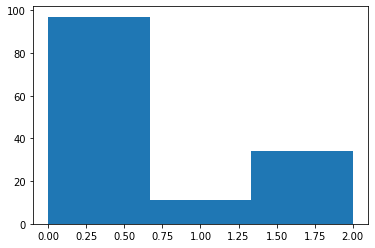

In [29]:
plt.hist(perf_model_small['course_id'],bins=3)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  3.,
         2.,  8., 11., 14.,  4.,  2.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.]),
 array([-0.96534919, -0.90288452, -0.84041986, -0.77795519, -0.71549052,
        -0.65302585, -0.59056118, -0.52809652, -0.46563185, -0.40316718,
        -0.34070251, -0.27823784, -0.21577318, -0.15330851, -0.09084384,
        -0.02837917,  0.0340855 ,  0.09655016,  0.15901483,  0.2214795 ,
         0.28394417,  0.34640884,  0.4088735 ,  0.47133817,  0.53380284,
         0.59626751,  0.65873218,  0.72119684,  0.78366151,  0.84612618,
         0.90859085]),
 <a list of 30 Patch objects>)

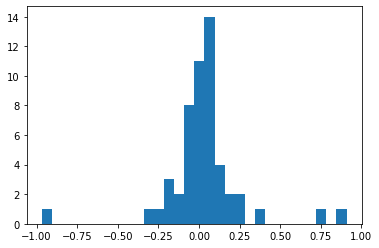

In [30]:
plt.hist(perf_model_small[perf_model_small['cumgame_coeff'] !=0]['cumgame_coeff'], bins = 30)

(array([1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 1., 0., 1., 0., 3., 1.,
        3., 5., 2., 9., 9., 9., 8., 0., 1., 2., 0., 1., 2.]),
 array([-0.56370914, -0.53870633, -0.51370352, -0.48870072, -0.46369791,
        -0.4386951 , -0.41369229, -0.38868948, -0.36368668, -0.33868387,
        -0.31368106, -0.28867825, -0.26367545, -0.23867264, -0.21366983,
        -0.18866702, -0.16366421, -0.13866141, -0.1136586 , -0.08865579,
        -0.06365298, -0.03865018, -0.01364737,  0.01135544,  0.03635825,
         0.06136106,  0.08636386,  0.11136667,  0.13636948,  0.16137229,
         0.18637509]),
 <a list of 30 Patch objects>)

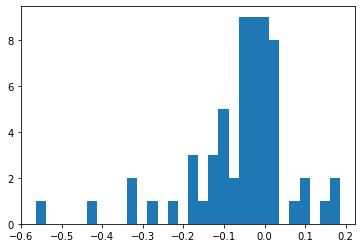

In [31]:
plt.hist(perf_model_small[perf_model_small['T_coeff'] !=0]['T_coeff'], bins = 30)

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1., 2., 0., 1., 0., 0., 2., 0., 1., 0., 3., 7., 6., 7., 3., 4., 2.,
        2., 1., 1., 0., 0., 2., 1., 2., 0., 0., 0., 0., 1.]),
 array([-78.70218709, -70.70822572, -62.71426435, -54.72030297,
        -46.7263416 , -38.73238022, -30.73841885, -22.74445748,
        -14.7504961 ,  -6.75653473,   1.23742664,   9.23138802,
         17.22534939,  25.21931076,  33.21327214,  41.20723351,
         49.20119489,  57.19515626,  65.18911763,  73.18307901,
         81.17704038,  89.17100175,  97.16496313, 105.1589245 ,
        113.15288587, 121.14684725, 129.14080862, 137.13477   ,
        145.12873137, 153.12269274, 161.11665412]),
 <a list of 30 Patch objects>)

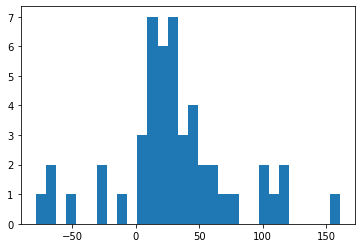

In [32]:
plt.hist(perf_model_small[perf_model_small['precip_coeff'] != 0]['precip_coeff'], bins = 30)

(array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  2.,  4.,
         3.,  9.,  8., 12.,  2.,  5.,  3.,  3.,  1.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.]),
 array([-1.02410432, -0.95303894, -0.88197357, -0.8109082 , -0.73984283,
        -0.66877746, -0.59771209, -0.52664672, -0.45558135, -0.38451597,
        -0.3134506 , -0.24238523, -0.17131986, -0.10025449, -0.02918912,
         0.04187625,  0.11294162,  0.18400699,  0.25507237,  0.32613774,
         0.39720311,  0.46826848,  0.53933385,  0.61039922,  0.68146459,
         0.75252996,  0.82359534,  0.89466071,  0.96572608,  1.03679145,
         1.10785682]),
 <a list of 30 Patch objects>)

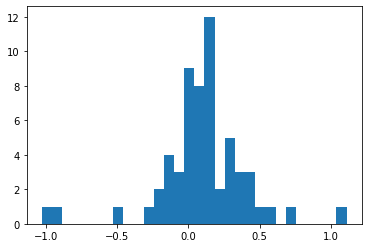

In [33]:
plt.hist(perf_model_small[perf_model_small['wspd_coeff'] != 0]['wspd_coeff'], bins = 30)

(array([1., 0., 0., 0., 0., 1., 0., 0., 2., 1., 2., 6., 4., 8., 5., 4., 7.,
        4., 3., 3., 1., 3., 1., 2., 0., 0., 0., 0., 0., 1.]),
 array([-0.34295793, -0.31682165, -0.29068537, -0.26454909, -0.23841281,
        -0.21227653, -0.18614025, -0.16000397, -0.13386769, -0.10773141,
        -0.08159513, -0.05545885, -0.02932258, -0.0031863 ,  0.02294998,
         0.04908626,  0.07522254,  0.10135882,  0.1274951 ,  0.15363138,
         0.17976766,  0.20590394,  0.23204022,  0.2581765 ,  0.28431278,
         0.31044906,  0.33658534,  0.36272162,  0.3888579 ,  0.41499418,
         0.44113046]),
 <a list of 30 Patch objects>)

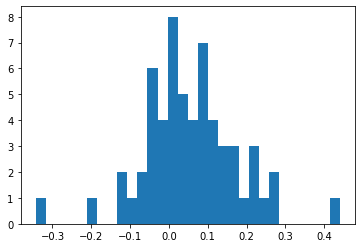

In [34]:
plt.hist(perf_model_small[perf_model_small['wgust_coeff'] != 0]['wgust_coeff'], bins = 30)

(array([1., 0., 1., 2., 1., 0., 0., 2., 0., 0., 4., 3., 3., 3., 6., 5., 6.,
        6., 1., 5., 2., 0., 2., 0., 0., 1., 0., 0., 1., 2.]),
 array([-1.51264701e-03, -1.41144548e-03, -1.31024396e-03, -1.20904244e-03,
        -1.10784091e-03, -1.00663939e-03, -9.05437864e-04, -8.04236339e-04,
        -7.03034815e-04, -6.01833291e-04, -5.00631767e-04, -3.99430243e-04,
        -2.98228719e-04, -1.97027194e-04, -9.58256703e-05,  5.37585388e-06,
         1.06577378e-04,  2.07778902e-04,  3.08980426e-04,  4.10181951e-04,
         5.11383475e-04,  6.12584999e-04,  7.13786523e-04,  8.14988047e-04,
         9.16189571e-04,  1.01739110e-03,  1.11859262e-03,  1.21979414e-03,
         1.32099567e-03,  1.42219719e-03,  1.52339872e-03]),
 <a list of 30 Patch objects>)

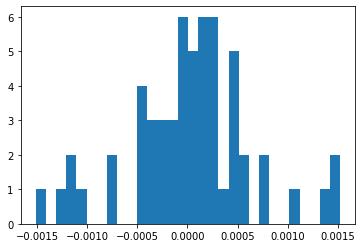

In [35]:
plt.hist(perf_model_small[perf_model_small['dirvar_coeff'] !=0]['dirvar_coeff'], bins = 30)

(array([20., 43., 47., 20.,  7.,  2.,  1.,  0.,  1.,  1.]),
 array([ 1.45891167,  5.8130205 , 10.16712934, 14.52123817, 18.875347  ,
        23.22945584, 27.58356467, 31.9376735 , 36.29178233, 40.64589117,
        45.        ]),
 <a list of 10 Patch objects>)

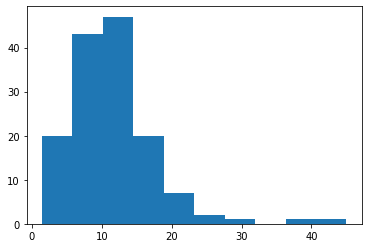

In [36]:
plt.hist(perf_model_small['mse'])

(array([64., 10., 21., 18.,  6., 11.,  3.,  2.,  4.,  3.]),
 array([0.        , 0.07770343, 0.15540685, 0.23311028, 0.3108137 ,
        0.38851713, 0.46622055, 0.54392398, 0.6216274 , 0.69933083,
        0.77703425]),
 <a list of 10 Patch objects>)

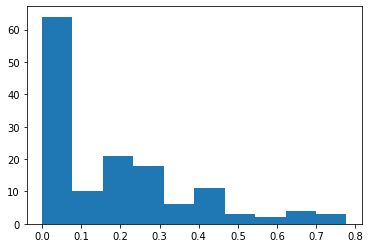

In [37]:
plt.hist(perf_model_small['prediction_score'])

In [38]:
coeff_count = []
for row in perf_model_small.iterrows():
    tmp_count = 0
    if row[1]['cumgame_coeff'] and (abs(row[1]['cumgame_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['T_coeff'] and (abs(row[1]['T_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['precip_coeff'] and (abs(row[1]['precip_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['wgust_coeff'] and (abs(row[1]['wgust_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['wspd_coeff'] and (abs(row[1]['wspd_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['dirvar_coeff'] and (abs(row[1]['dirvar_coeff']) > 0.000001):
        tmp_count += 1
    coeff_count.append(tmp_count)
perf_model_small['coeff_count'] = coeff_count
perf_model_small.head()

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,T_coeff,alpha,attempts,course_id,cumgame_coeff,dirvar_coeff,intercept,l1,mse,n_iter,n_values,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff,wx_impact,coeff_count
5,-0.042129,0.691633,4.0,2,-0.000000,0.000000,54.873446,0.90,10.188281,8.0,23,Bob Montes,60.082524,0.269900,0.0,0.273165,0.000000,21.624142,3
6,-0.000000,1.233265,1.0,0,0.000000,0.000000,51.000000,0.99,3.272727,1.0,11,Dennis Warsen,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0
7,-0.322203,0.843878,7.0,1,-0.000000,-0.000000,77.291950,0.99,6.244706,4.0,14,Dennis Warsen,NaN,0.612670,1.0,0.086454,0.000000,16.346283,2
8,-0.000000,1.029388,1.0,2,-0.000000,-0.000000,52.617304,0.70,14.227471,14.0,53,Dennis Warsen,0.000000,0.106768,0.0,0.155445,0.008097,6.379739,2
10,-0.002452,2.048776,1.0,1,0.234117,-0.000124,65.243669,0.05,9.966810,5.0,8,Gonzalo Arestizabal,NaN,0.202655,1.0,-0.207136,0.367187,16.968251,5


In [39]:
perf_model_small.coeff_count.value_counts()

0    53
5    24
6    21
1    17
3    12
2    11
4     4
Name: coeff_count, dtype: int64

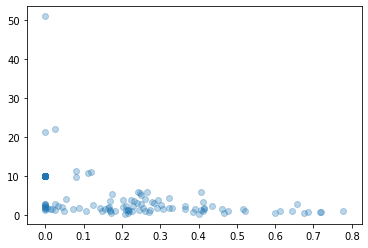

In [40]:
plt.scatter(x=perf_model_small.prediction_score,y=perf_model_small.alpha, alpha = 0.3)

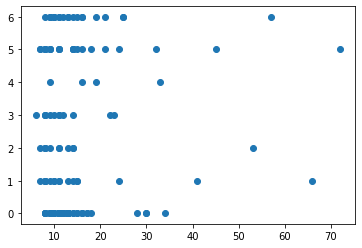

In [41]:
plt.scatter(x=perf_model_small.n_values, y=perf_model_small.coeff_count)

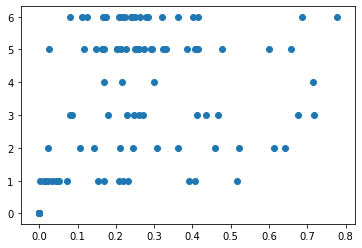

In [42]:
plt.scatter(x=perf_model_small.prediction_score, y=perf_model_small.coeff_count)

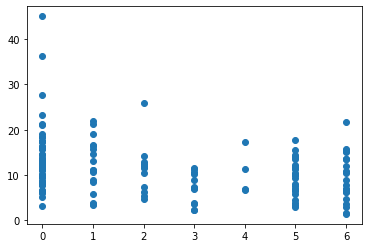

In [43]:
plt.scatter(x=perf_model_small.coeff_count, y=perf_model_small.mse)

In [44]:
[(col, perf_model_small[perf_model_small[col] != 0][col].mean(), 
 perf_model_small[perf_model_small[col] != 0][col].std()) for col in list(perf_model_small.columns) if col != 'player']

[('T_coeff', -0.05765474746837644, 0.12831605544684863),
 ('alpha', 5.223866053463639, 5.859230552592705),
 ('attempts', 3.443661971830986, 3.532071194127827),
 ('course_id', 1.7555555555555555, 0.43461349368017665),
 ('cumgame_coeff', 0.03209539459134994, 0.24358467952540458),
 ('dirvar_coeff', 2.984103102562307e-05, 0.0006159951810763094),
 ('intercept', 58.63613012114772, 6.656120007121993),
 ('l1', 0.4180281690140845, 0.35587518617775143),
 ('mse', 11.37511127554431, 6.2375049630351915),
 ('n_iter', 4.26056338028169, 4.70502911480171),
 ('n_values', 14.76056338028169, 10.451461316580703),
 ('precip_coeff', 30.153197287522254, 47.130174544574466),
 ('prediction_score', 0.27862813430564887, 0.18348916096192083),
 ('removed_corr', 1.03125, 0.1767766952966369),
 ('wgust_coeff', 0.05333299222368558, 0.12475951704320437),
 ('wspd_coeff', 0.0972093090267492, 0.3229108821919753),
 ('wx_impact', 14.837428278093443, 7.045250140594051),
 ('coeff_count', 3.7865168539325844, 1.8857835971502404)

In [45]:
perf_model_small.mean()

T_coeff             -0.024767
alpha                5.223866
attempts             3.443662
course_id            0.556338
cumgame_coeff        0.011753
dirvar_coeff         0.000012
intercept           58.636130
l1                   0.418028
mse                 11.375111
n_iter               4.260563
n_values            14.760563
precip_coeff        13.431879
prediction_score     0.174633
removed_corr         0.232394
wgust_coeff          0.022317
wspd_coeff           0.040390
wx_impact            9.195026
coeff_count          2.373239
dtype: float64

In [46]:
perf_model_small.std()

T_coeff              0.088469
alpha                5.859231
attempts             3.532071
course_id            0.854895
cumgame_coeff        0.147315
dirvar_coeff         0.000388
intercept            6.656120
l1                   0.355875
mse                  6.237505
n_iter               4.705029
n_values            10.451461
precip_coeff        34.710602
prediction_score     0.198249
removed_corr         0.440269
wgust_coeff          0.084531
wspd_coeff           0.212610
wx_impact            9.103636
coeff_count          2.365860
dtype: float64

In [47]:
perf_model_small[['player','course_id','mse','coeff_count', 'wx_impact']].sort_values(by='mse')

,player,course_id,mse,coeff_count,wx_impact
969,Jake Ward,0,1.458912,6,17.968040
1023,Marquis Mallen,0,1.673289,6,10.351659
23,Juan Fielding,2,2.257454,3,15.121898
798,Dan Santini,0,2.302873,3,19.092629
873,Trevor Duckworth,0,2.945086,5,21.706772
1074,Randy Waters,0,3.060750,6,25.917191
6,Dennis Warsen,0,3.272727,0,0.000000
1077,Ryan Santos,0,3.341589,1,5.215936
260,Beau Griffin,2,3.512962,5,17.476511
720,Niel Jones,0,3.631942,6,11.559765


In [48]:
perf_model_small.sort_values(by='prediction_score',ascending=False).head()

,T_coeff,alpha,attempts,course_id,cumgame_coeff,dirvar_coeff,intercept,l1,mse,n_iter,n_values,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff,wx_impact,coeff_count
969,-0.179557,0.825510,1.0,0,0.126815,0.000068,67.973392,0.05,1.458912,8.0,9,Jake Ward,21.985823,0.777034,0.0,0.089293,0.161718,17.968040,6
444,-0.326041,0.621633,1.0,0,0.083822,0.000000,70.000860,0.70,3.679887,7.0,12,Joe Dannels,55.013615,0.718585,0.0,-0.000000,-0.000000,21.293691,3
204,-0.000000,0.567755,5.0,0,0.264025,0.000060,64.658658,0.80,6.735710,8.0,16,Hugh Harrell,100.973314,0.716204,0.0,0.000000,0.551094,26.770823,4
1074,-0.223148,0.727755,6.0,0,0.020666,-0.001141,77.740431,0.05,3.060750,9.0,9,Randy Waters,9.322130,0.686969,0.0,0.012937,0.183377,25.917191,6
19,-0.266349,0.417755,1.0,1,-0.000000,-0.000386,73.822127,0.99,3.825563,13.0,11,Jon Braidman,NaN,0.675391,1.0,0.064679,-0.000000,17.099978,3


In [49]:
perf_model_df.mean()

T_coeff             -0.024767
alpha                5.257266
attempts             3.426573
course_id            1.000000
cumgame_coeff        0.010912
dirvar_coeff         0.000012
intercept           61.766279
l1                   0.417902
mse                 22.924212
n_iter               4.237762
n_values             2.109731
precip_coeff        13.431879
prediction_score     0.160199
removed_corr         0.321429
wgust_coeff          0.022159
wspd_coeff           0.040107
wx_impact            9.130725
dtype: float64

In [50]:
perf_model_df.std()

T_coeff              0.088469
alpha                5.852208
attempts             3.525540
course_id            0.816778
cumgame_coeff        0.574644
dirvar_coeff         0.000387
intercept            8.852903
l1                   0.354623
mse                 15.154575
n_iter               4.696355
n_values             5.458251
precip_coeff        34.710602
prediction_score     0.193411
removed_corr         0.530915
wgust_coeff          0.084251
wspd_coeff           0.211887
wx_impact            9.104054
dtype: float64

In [51]:
perf_model_with_zeros = perf_model_df.fillna(0)
perf_model_with_zeros.head()

,T_coeff,alpha,attempts,course_id,cumgame_coeff,dirvar_coeff,intercept,l1,mse,n_iter,n_values,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff,wx_impact
0,0.0,0.0,0.0,0,0.0,0.0,68.111111,0.0,18.361111,0.0,0,Ben Horst,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1,0.0,0.0,68.111111,0.0,18.361111,0.0,0,Ben Horst,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,10.0,1.0,2,-0.0,-0.0,68.111111,0.4,16.320988,1.0,9,Ben Horst,0.0,0.000000,2.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0,0.0,0.0,54.607143,0.0,14.025132,0.0,0,Bob Montes,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1,0.1,0.0,52.400000,0.0,6.620000,0.0,5,Bob Montes,0.0,0.003012,1.0,0.0,0.0,0.0


In [52]:
perf_model_df['mse'].value_counts().sort_index().head()

1.111222    59
1.260000     1
1.333333     2
1.333333     1
1.458912     1
Name: mse, dtype: int64

In [53]:
perf_model_with_zeros.to_csv('../score_model_data/score_model.csv')
perf_model_with_zeros.to_csv('../score_model_data/score_model_20190805a.csv')
len(perf_model_with_zeros)

1449

Text(0, 0.5, 'Number of Player/Course Series')

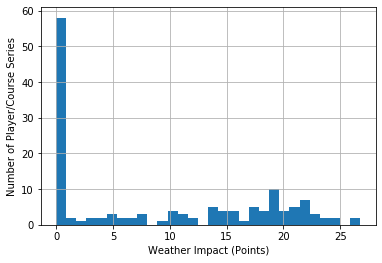

In [78]:
perf_model_df['wx_impact'].hist(bins=30)
plt.xlabel('Weather Impact (Points)')
plt.ylabel('Number of Player/Course Series')

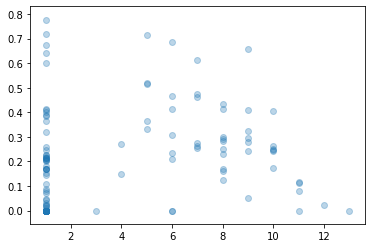

In [55]:
plt.scatter(x=perf_model_small['attempts'], y=perf_model_small['prediction_score'], alpha = 0.3)

In [105]:
test2 = all_df[(all_df.Name == 'Hugh Harrell') & (all_df.course_id == 0)].reset_index()
test2b = perf_model_small[(perf_model_small.player == 'Hugh Harrell') & (perf_model_small.course_id == 0)]
test2.head(12)

,index,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
0,1559,Hugh Harrell,65,0.00,65.00,2018-11-04 07:30:00,0,2018-11-04,57.998329,233.283598,2.701309,12.000000,82.412754,0.000768,-2.212663,-1.189524,9.066667,168.930299,595.295093
1,1665,Hugh Harrell,68,0.00,68.00,2018-11-11 07:30:00,0,2018-11-11,62.987163,59.560057,5.091894,15.866667,26.821613,0.000000,2.632290,3.792724,2.382222,115.436274,111.370212
2,1751,Hugh Harrell,69,5.49,74.49,2018-11-18 07:30:00,0,2018-11-18,51.214855,73.616546,3.325604,10.266667,93.159300,0.000000,2.164172,1.545328,3.262222,452.545764,1039.493978
3,1869,Hugh Harrell,64,1.13,65.13,2018-11-25 07:30:00,0,2018-11-25,57.023188,80.344928,1.289855,6.800000,88.214493,0.000000,0.807230,0.670447,0.560000,266.490351,154.904818
4,1975,Hugh Harrell,68,3.31,71.31,2018-12-02 07:30:00,0,2018-12-02,51.962407,74.183519,1.531852,10.066667,66.050370,0.000000,0.973358,0.952229,7.128889,346.478558,1050.367545
5,2088,Hugh Harrell,64,-1.61,62.39,2018-12-09 07:30:00,0,2018-12-09,49.491667,68.116667,3.919444,13.133333,90.988889,0.000000,2.100778,2.822686,2.915556,490.203981,41.108702
6,2234,Hugh Harrell,65,3.35,68.35,2018-12-16 07:30:00,0,2018-12-16,59.633333,130.906614,4.069841,19.533333,81.322751,0.000000,2.057238,-2.256748,13.182222,270.720132,2851.553387
7,2321,Hugh Harrell,63,0.80,63.80,2018-12-23 07:30:00,0,2018-12-23,55.744082,92.798551,0.226570,4.200000,78.270169,0.000000,0.191350,0.049464,3.093333,452.046201,544.567717
8,2409,Hugh Harrell,70,2.40,72.40,2018-12-30 07:30:00,0,2018-12-30,50.780123,104.042487,1.036966,8.000000,81.401499,0.000000,0.283379,0.465501,0.000000,3660.778308,0.000000
9,2484,Hugh Harrell,83,11.22,94.22,2019-01-06 07:30:00,0,2019-01-06,51.505556,153.133333,4.384722,20.933333,89.798611,0.105625,0.829178,-3.227827,6.995556,214.376551,906.500313


In [93]:
test2b

,T_coeff,alpha,attempts,course_id,cumgame_coeff,dirvar_coeff,intercept,l1,mse,n_iter,n_values,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff,wx_impact,coeff_count
204,-0.0,0.567755,5.0,0,0.264025,0.00006,64.658658,0.8,6.73571,8.0,16,Hugh Harrell,100.973314,0.716204,0.0,0.0,0.551094,26.770823,4


In [98]:
model3_df = pd.read_csv('../score_model_data/score_model_20190801a.csv')

In [99]:
test3 = model3_df[(model3_df.player == 'Hugh Harrell') & (model3_df.course_id == 0)]
test3.head()

,Unnamed: 0,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff
204,204,-0.118923,0,0.0,0.000437,71.54369,7.908632,16,Hugh Harrell,109.89434,0.666786,0.0,0.0,0.944974


In [108]:
test2['est_score_1'] = test2b.intercept.mean() + test2b.T_coeff.mean() * test2.weighted_T + \
    test2b.cumgame_coeff.mean() * len(test2) + test2b.dirvar_coeff.mean() * test2.w_dir_var + test2b.precip_coeff.mean() * test2.weighted_precip + \
    test2b.wspd_coeff.mean() * test2.weighted_w_spd + test2b.wgust_coeff.mean() * test2.weighted_w_gust

In [111]:
test2['est_score_2'] = test3.intercept.mean() + test3.T_coeff.mean() * test2.weighted_T + \
    test3.cumgame_coeff.mean() * len(test2) + test3.dirvar_coeff.mean() * test2.w_dir_var + test3.precip_coeff.mean() * test2.weighted_precip + \
    test3.wspd_coeff.mean() * test2.weighted_w_spd + test3.wgust_coeff.mean() * test2.weighted_w_gust

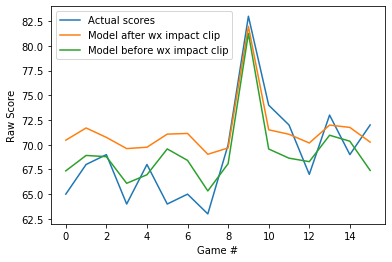

In [116]:
plt.plot(test2.Raw, label = 'Actual scores')
plt.plot(test2.est_score_1, label = 'Model after wx impact clip')
plt.plot(test2.est_score_2, label = 'Model before wx impact clip')
plt.xlabel('Game #')
plt.ylabel('Raw Score')
plt.legend(loc = 'best')

In [113]:
wx_impact_1 = test2b.T_coeff.mean() * 40  + test2b.dirvar_coeff.mean() * 10000 + test2b.precip_coeff.mean() * 0.15 + \
    test2b.wspd_coeff.mean() * 20 + test2b.wgust_coeff.mean() * 40
wx_impact_1

26.770823210940108

In [114]:
wx_impact_2 = test3.T_coeff.mean() * 40  + test3.dirvar_coeff.mean() * 10000 + test3.precip_coeff.mean() * 0.15 + \
    test3.wspd_coeff.mean() * 20 + test3.wgust_coeff.mean() * 40
wx_impact_2

34.9930238892488